In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Configuration ===
RESULT_DIR = Path("result/yearly")
MODEL = "gpt-4o"
YEARS = list(range(2012, 2023))
LABELS = list("ABCDEFG")

# === Load & Combine Data ===
dfs = []
for year in YEARS:
    file_path = RESULT_DIR / f"labelled_{MODEL}_{year}_sample100.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["year"] = year
        dfs.append(df)
    else:
        print(f"⚠️ Missing file: {file_path}")

all_data = pd.concat(dfs, ignore_index=True)


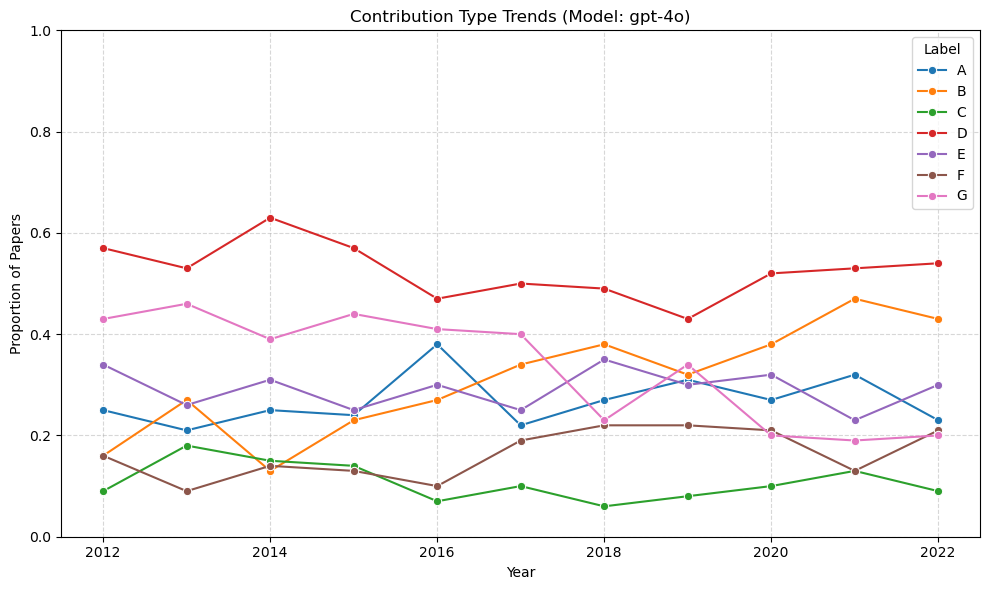

In [12]:
# === Aggregate: % of papers with each label per year ===
trend_df = (
    all_data.groupby("year")[LABELS]
    .mean()
    .reset_index()
    .melt(id_vars="year", var_name="Label", value_name="Proportion")
)

# === Plot ===
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_df, x="year", y="Proportion", hue="Label", marker="o")
plt.title(f"Contribution Type Trends (Model: {MODEL})")
plt.ylabel("Proportion of Papers")
plt.xlabel("Year")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

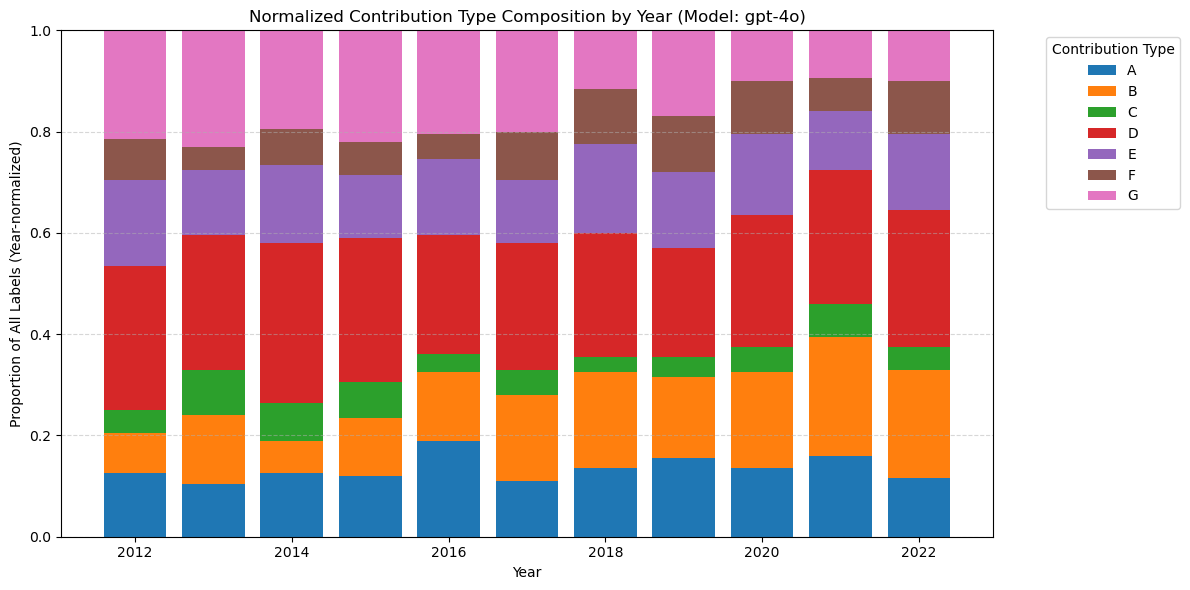

In [13]:
# === Compute normalized proportions (row-wise) ===
label_counts = (
    all_data.groupby("year")[LABELS]
    .sum()
    .reset_index()
    .set_index("year")
)

normalized = label_counts.div(label_counts.sum(axis=1), axis=0)

# === Plot ===
plt.figure(figsize=(12, 6))
bottom = None

for label in LABELS:
    plt.bar(
        normalized.index,
        normalized[label],
        bottom=bottom,
        label=label
    )
    bottom = normalized[label] if bottom is None else bottom + normalized[label]

plt.title(f"Normalized Contribution Type Composition by Year (Model: {MODEL})")
plt.ylabel("Proportion of All Labels (Year-normalized)")
plt.xlabel("Year")
plt.ylim(0, 1)
plt.legend(title="Contribution Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()